In [ ]:
# Update keras to version 3
!pip install keras keras-tuner  --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import pandas as pd

import numpy as np
import gdown
import shutil

import keras_tuner
import tensorflow
import keras
from keras import Sequential, datasets, initializers, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, AdamW
from keras.layers import (
    Flatten, BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
    Input, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, Conv2DTranspose
)
from keras.models import Model, Sequential
from keras.utils import load_img, img_to_array, to_categorical
from keras_tuner.engine.hyperparameters import HyperParameters

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from glob import iglob
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, fbeta_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

## Original data

In [ ]:
X_train = np.load('/content/drive/My Drive/DL_FinalProject/data/X_train.npy')
y_train = np.load('/content/drive/My Drive/DL_FinalProject/data/y_train.npy')
X_valid = np.load('/content/drive/My Drive/DL_FinalProject/data/X_valid.npy')
y_valid = np.load('/content/drive/My Drive/DL_FinalProject/data/y_valid.npy')
#X_test = np.load('/content/drive/My Drive/DL_FinalProject/data/X_test.npy')
#y_test = np.load('/content/drive/My Drive/DL_FinalProject/data/y_test.npy')

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
#print(X_test.shape, y_test.shape)

(5229, 75, 100, 3) (5229, 7)
(1120, 75, 100, 3) (1120, 7)


Instead of loading the entire dataset into memory, ImageDataGenerator efficiently loads and processes the data on-the-fly. This is especially advantageous for very large datasets that do not fit into memory.

In [ ]:
train_datagen = ImageDataGenerator()
train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_valid)

## Balanced data

In [ ]:
X_balanced_6000_train = np.load('/content/drive/My Drive/DL_FinalProject/data/X_balanced_6000_train.npy')
y_balanced_6000_train = np.load('/content/drive/My Drive/DL_FinalProject/data/y_balanced_6000_train.npy')

In [ ]:
train_datagen_6000 = ImageDataGenerator()
train_datagen_6000.fit(X_balanced_6000_train)

In [ ]:
X_balanced_6000_train.shape, y_balanced_6000_train.shape

((42000, 75, 100, 3), (42000, 7))

In [ ]:
class_counts = np.sum(y_balanced_6000_train, axis=0)

for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} occurrences")

Class 0: 6000.0 occurrences
Class 1: 6000.0 occurrences
Class 2: 6000.0 occurrences
Class 3: 6000.0 occurrences
Class 4: 6000.0 occurrences
Class 5: 6000.0 occurrences
Class 6: 6000.0 occurrences


In [ ]:
#meta_data_train = np.load('/content/drive/My Drive/DL_FinalProject/data/meta_data_train.npy')
#meta_data_valid = np.load('/content/drive/My Drive/DL_FinalProject/data/meta_data_valid.npy')
#meta_data_test = np.load('/content/drive/My Drive/DL_FinalProject/data/meta_data_test.npy')

In [ ]:
#print(meta_data_train.shape, y_train.shape)
#print(X_valid.shape, y_valid.shape)
#print(X_test.shape, y_test.shape)

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    num_metrics = len(metrics)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        ax = axs[n // 2, n % 2]
        ax.plot(history.epoch, history.history[metric], label='Train')
        ax.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(name)

        if metric == 'loss':
            ax.set_ylim([0, max(history.history[metric])])
        else:
            ax.set_ylim([0, 1])

        ax.legend()

        # Print the values of the metric next to the plot
        train_value = round(history.history[metric][-1], 3)
        val_value = round(history.history['val_'+metric][-1], 3)
        ax.text(0.5, 0.5, f"Train: {train_value}\nVal: {val_value}", transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_and_print_scores(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    print("Matthews Correlation Coefficient (MCC): {:.4f}".format(mcc))

    fbeta_macro = fbeta_score(y_true, y_pred, average='macro', beta=2.0)
    print("F-beta Score (macro averaging): {:.4f}".format(fbeta_macro))

    fbeta_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2.0)
    print("F-beta Score (weighted averaging): {:.4f}".format(fbeta_weighted))

# Basic CNN model development. Original data with no weights

In [ ]:
num_classes = y_train.shape[1]

In [ ]:
metrics = [
      keras.metrics.FBetaScore(beta=2.0, name='fbeta_score'),
      keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
# Define the model building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Input(shape=X_train.shape[1:]))

    # Convolutional layers with varying hyperparameters
    for i in range(hp.Int('n_hidden_layers', 1, 4, default=2)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=8, max_value=256, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(hp.Float(f'l2_{i}', min_value=0.0,
                                                        max_value=0.1, step=0.01))
        ))

        pool_size = (2, 2)
        if model.output_shape[1] >= pool_size[0] and model.output_shape[2] >= pool_size[1]:
          if hp.Choice(f'pooling_{i}', ['max', 'avg']) == 'max':
              model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
          else:
              model.add(AveragePooling2D(pool_size=pool_size, padding='same'))

          model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0,
                                    max_value=0.5, step=0.05)))

    if hp.Boolean('global_average_pooling'):
        model.add(GlobalAveragePooling2D())
    else:
        model.add(GlobalMaxPooling2D())

    model.add(Dropout(hp.Float('dropout_rate_dense', min_value=0.0,
                                      max_value=0.5, step=0.1)))

    model.add(Dense(y_train.shape[1], activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(
        optimizer=Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model

In [ ]:
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_prc", direction="max"),
    max_epochs=40,
    factor=3,
    hyperband_iterations=1,
    directory='/content/drive/My Drive/HPOs/HPO_BasicCNN_original_data',
    project_name="CNNModel_HPO"
)

In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

In [ ]:
batch_size = 128

tuner.search(train_datagen.flow(X_train, y_train, batch_size=batch_size),
             batch_size=128,
             epochs=30,
             validation_data=val_datagen.flow(X_valid, y_valid),
             callbacks = [early_stopping_monitor, reduce_lr])

Trial 21 Complete [00h 00m 30s]
val_prc: 0.7871368527412415

Best val_prc So Far: 0.7931771874427795
Total elapsed time: 00h 22m 00s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
1                 |3                 |n_hidden_layers
56                |184               |filters_0
5                 |3                 |kernel_size_0
0.05              |0.05              |l2_0
avg               |max               |pooling_0
0.05              |0.35              |dropout_rate_0
216               |168               |filters_1
5                 |5                 |kernel_size_1
0.06              |0.01              |l2_1
max               |max               |pooling_1
0.2               |0.05              |dropout_rate_1
True              |True              |global_average_pooling
0.4               |0.2               |dropout_rate_dense
0.00063587        |0.0012124         |learning_rate
104               |184               |filters_2
3                 |5      

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'n_hidden_layers': 3, 'filters_0': 184, 'kernel_size_0': 3, 'l2_0': 0.05, 'pooling_0': 'max', 'dropout_rate_0': 0.35000000000000003, 'filters_1': 168, 'kernel_size_1': 5, 'l2_1': 0.01, 'pooling_1': 'max', 'dropout_rate_1': 0.05, 'global_average_pooling': True, 'dropout_rate_dense': 0.2, 'learning_rate': 0.0012124065560207727, 'filters_2': 184, 'kernel_size_2': 5, 'l2_2': 0.01, 'pooling_2': 'max', 'dropout_rate_2': 0.0, 'filters_3': 88, 'kernel_size_3': 3, 'l2_3': 0.08, 'pooling_3': 'avg', 'dropout_rate_3': 0.45, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}


In [ ]:
# we saved our model to have it available to load
best_model = tuner.get_best_models()[0]
#best_model.save('results/best_model_hpo_with_weights.keras')
#best_model = keras.models.load_model('/content/best_model_hpo_with_weights.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 100, 184)        │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 38, 50, 184)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 50, 184)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 38, 50, 168)         │         772,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 25, 168)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 25, 168)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 25, 184)         │         772,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 13, 184)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 13, 184)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 184)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 184)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           1,295 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,552,399 (5.92 MB)

 Trainable params: 1,552,399 (5.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 50
batch_size = 128

model_best_build = tuner.hypermodel.build(best_hps)
history = model_best_build.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_valid, y_valid),
                    callbacks = [early_stopping_monitor, reduce_lr])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - cat_accuracy: 0.6719 - fbeta_score: 0.1335 - loss: 3.3494 - prc: 0.6937 - precision: 0.7455 - recall: 0.6288 - val_cat_accuracy: 0.7232 - val_fbeta_score: 0.1327 - val_loss: 1.3231 - val_prc: 0.7896 - val_precision: 0.7402 - val_recall: 0.6741 - learning_rate: 0.0012
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - cat_accuracy: 0.7150 - fbeta_score: 0.1323 - loss: 1.2448 - prc: 0.7724 - precision: 0.7644 - recall: 0.6194 - val_cat_accuracy: 0.7232 - val_fbeta_score: 0.1327 - val_loss: 1.0347 - val_prc: 0.7946 - val_precision: 0.8169 - val_recall: 0.6054 - learning_rate: 0.0012
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - cat_accuracy: 0.7213 - fbeta_score: 0.1326 - loss: 1.0307 - prc: 0.7895 - precision: 0.7987 - recall: 0.6118 - val_cat_accuracy: 0.7232 - val_fbeta_score: 0.1327 - val_loss: 0.9897 - val_prc: 0.7925 - val_precision: 0.7970 - val_recall: 0.6098 - learning_rate: 0.0012
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    num_metrics = len(metrics)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        ax = axs[n // 2, n % 2]
        ax.plot(history.epoch, history.history[metric], label='Train')
        ax.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(name)

        if metric == 'loss':
            ax.set_ylim([0, max(history.history[metric])])
        else:
            ax.set_ylim([0, 1])

        ax.legend()

        # Print the values of the metric next to the plot
        train_value = round(history.history[metric][-1], 3)
        val_value = round(history.history['val_'+metric][-1], 3)
        ax.text(0.5, 0.5, f"Train: {train_value}\nVal: {val_value}", transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_and_print_scores(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    print("Matthews Correlation Coefficient (MCC): {:.4f}".format(mcc))

    fbeta_macro = fbeta_score(y_true, y_pred, average='macro', beta=2.0)
    print("F-beta Score (macro averaging): {:.4f}".format(fbeta_macro))

    fbeta_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2.0)
    print("F-beta Score (weighted averaging): {:.4f}".format(fbeta_weighted))

In [ ]:
#model_best_build.save('fp_model_best_build.keras')

In [ ]:
#model_best_build.save("fp_model_best_build.h5")

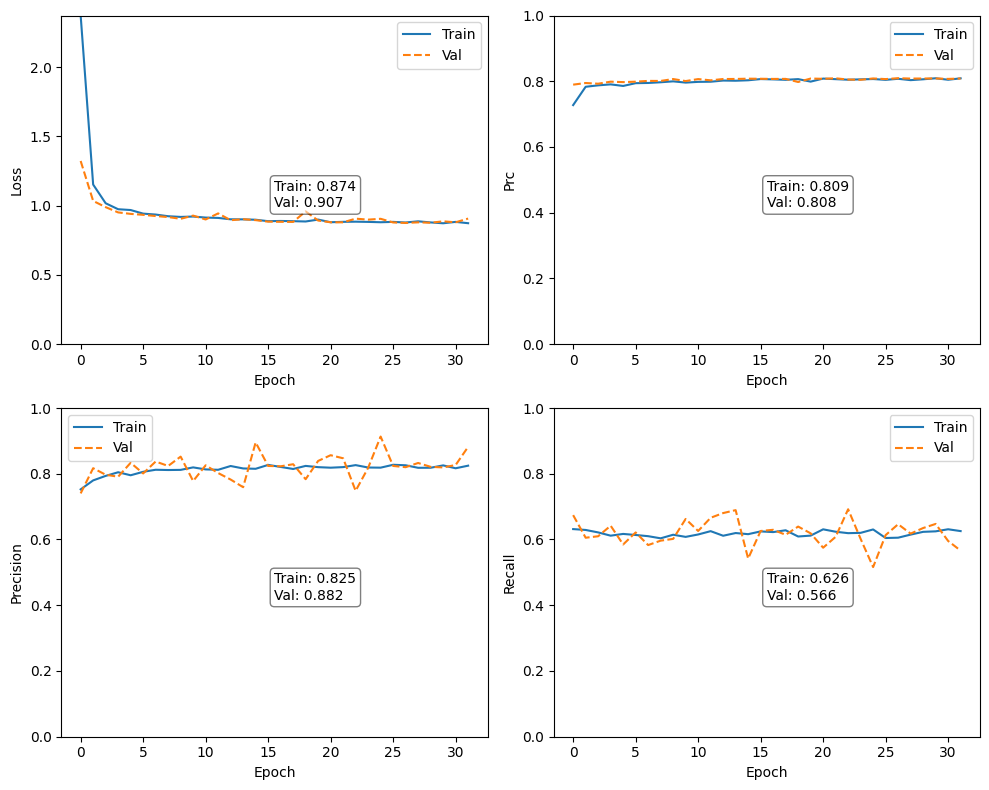

In [ ]:
plot_metrics(history)

In [ ]:
class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

display_labels = [class_names[i] for i in range(len(class_names))]

In [ ]:
model_best_build_preds = model_best_build.predict(X_valid)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


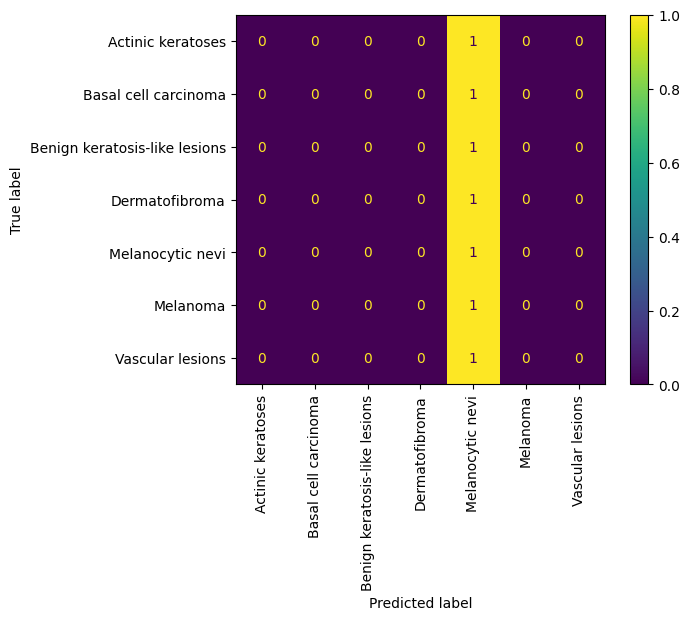

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_valid.argmax(axis=1),
                                        model_best_build_preds.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid.argmax(axis=1),
                            model_best_build_preds.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.00      0.00      0.00        34
         Basal cell carcinoma       0.00      0.00      0.00        49
Benign keratosis-like lesions       0.00      0.00      0.00       109
               Dermatofibroma       0.00      0.00      0.00        11
             Melanocytic nevi       0.72      1.00      0.84       810
                     Melanoma       0.00      0.00      0.00        92
             Vascular lesions       0.00      0.00      0.00        15

                     accuracy                           0.72      1120
                    macro avg       0.10      0.14      0.12      1120
                 weighted avg       0.52      0.72      0.61      1120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
calculate_and_print_scores(y_valid.argmax(axis=1), model_best_build_preds.argmax(axis=1))

Matthews Correlation Coefficient (MCC): 0.0000
F-beta Score (macro averaging): 0.1327
F-beta Score (weighted averaging): 0.6718


# Basic CNN model development. Original data with class weights

In [ ]:
num_classes = y_train.shape[1]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

In [ ]:
class_weight_dict

{0: 4.69811320754717,
 1: 3.2620087336244543,
 2: 1.4675834970530452,
 3: 14.647058823529411,
 4: 0.19751454257006876,
 5: 1.7372093023255815,
 6: 10.826086956521738}

In [ ]:
metrics = [
      keras.metrics.FBetaScore(beta=2.0, name='fbeta_score'),
      keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
# Define the model building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Input(shape=X_train.shape[1:]))

    # Convolutional layers with varying hyperparameters
    for i in range(hp.Int('n_hidden_layers', 1, 4, default=2)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=8, max_value=256, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(hp.Float(f'l2_{i}', min_value=0.0,
                                                        max_value=0.1, step=0.01))
        ))

        pool_size = (2, 2)
        if model.output_shape[1] >= pool_size[0] and model.output_shape[2] >= pool_size[1]:
          if hp.Choice(f'pooling_{i}', ['max', 'avg']) == 'max':
              model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
          else:
              model.add(AveragePooling2D(pool_size=pool_size, padding='same'))

          model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0,
                                    max_value=0.5, step=0.05)))

    if hp.Boolean('global_average_pooling'):
        model.add(GlobalAveragePooling2D())
    else:
        model.add(GlobalMaxPooling2D())

    model.add(Dropout(hp.Float('dropout_rate_dense', min_value=0.0,
                                      max_value=0.5, step=0.1)))

    model.add(Dense(y_train.shape[1], activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(
        optimizer=Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model

In [ ]:
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_prc", direction="max"),
    max_epochs=40,
    factor=3,
    hyperband_iterations=1,
    directory='/content/drive/My Drive/HPOs/HPO_BasicCNN_original_data',
    project_name="CNNModel_HPO"
)

In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

In [ ]:
import shutil

In [ ]:
shutil.move("results", "/content/drive/My Drive/HPOs/HPO_BasicCNN_original_data")

'/content/drive/My Drive/HPOs/HPO_BasicCNN_original_data'

In [ ]:
batch_size = 128

tuner.search(train_datagen.flow(X_train, y_train, batch_size=batch_size),
             batch_size=128,
             epochs=30,
             validation_data=val_datagen.flow(X_valid, y_valid),
             class_weight=class_weight_dict,
             callbacks = [early_stopping_monitor, reduce_lr])

Trial 50 Complete [00h 00m 34s]
val_prc: 0.6373974084854126

Best val_prc So Far: 0.7725467681884766
Total elapsed time: 00h 36m 23s

Search: Running Trial #51

Value             |Best Value So Far |Hyperparameter
3                 |3                 |n_hidden_layers
168               |168               |filters_0
3                 |3                 |kernel_size_0
0                 |0                 |l2_0
avg               |avg               |pooling_0
0                 |0                 |dropout_rate_0
120               |120               |filters_1
5                 |5                 |kernel_size_1
0.04              |0.04              |l2_1
max               |max               |pooling_1
0                 |0                 |dropout_rate_1
False             |False             |global_average_pooling
0                 |0                 |dropout_rate_dense
0.00080835        |0.00080835        |learning_rate
136               |136               |filters_2
5                 |5      

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'n_hidden_layers': 3, 'filters_0': 168, 'kernel_size_0': 3, 'l2_0': 0.0, 'pooling_0': 'avg', 'dropout_rate_0': 0.0, 'filters_1': 120, 'kernel_size_1': 5, 'l2_1': 0.04, 'pooling_1': 'max', 'dropout_rate_1': 0.0, 'global_average_pooling': False, 'dropout_rate_dense': 0.0, 'learning_rate': 0.0008083461993086267, 'filters_2': 136, 'kernel_size_2': 5, 'l2_2': 0.0, 'pooling_2': 'max', 'dropout_rate_2': 0.05, 'filters_3': 152, 'kernel_size_3': 3, 'l2_3': 0.06, 'pooling_3': 'avg', 'dropout_rate_3': 0.0, 'tuner/epochs': 14, 'tuner/initial_epoch': 5, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0040'}


In [ ]:
# we saved our model to have it available to load
best_model = tuner.get_best_models()[0]
#best_model.save('results/best_model_hpo_with_weights.keras')
#best_model = keras.models.load_model('/content/best_model_hpo_with_weights.keras')

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 100, 168)        │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 38, 50, 168)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 50, 168)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 38, 50, 120)         │         504,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 25, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 25, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 25, 136)         │         408,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 13, 136)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 13, 136)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 136)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 136)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             959 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 917,919 (3.50 MB)

 Trainable params: 917,919 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 50
batch_size = 128

model_best_build = tuner.hypermodel.build(best_hps)
history = model_best_build.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_valid, y_valid),
                    class_weight=class_weight_dict,
                    callbacks = [early_stopping_monitor, reduce_lr])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - cat_accuracy: 0.2272 - fbeta_score: 0.1043 - loss: 4.8392 - prc: 0.2915 - precision: 0.3517 - recall: 0.0202 - val_cat_accuracy: 0.4714 - val_fbeta_score: 0.2254 - val_loss: 1.7555 - val_prc: 0.5496 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - cat_accuracy: 0.5055 - fbeta_score: 0.2065 - loss: 1.9098 - prc: 0.6036 - precision: 0.9760 - recall: 0.2778 - val_cat_accuracy: 0.5179 - val_fbeta_score: 0.2402 - val_loss: 1.5212 - val_prc: 0.6143 - val_precision: 0.9842 - val_recall: 0.2786
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - cat_accuracy: 0.5008 - fbeta_score: 0.2590 - loss: 1.7494 - prc: 0.6024 - precision: 0.9679 - recall: 0.3099 - val_cat_accuracy: 0.4750 - val_fbeta_score: 0.2802 - val_loss: 1.3773 - val_prc: 0.6146 - val_precision: 0.9691 - val_recall: 0.3080
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - cat_accuracy: 0.5352 - fbeta_score: 0.3131 - loss: 

In [ ]:
#model_best_build.save('fp_model_best_build.keras')

In [ ]:
#model_best_build.save("fp_model_best_build.h5")

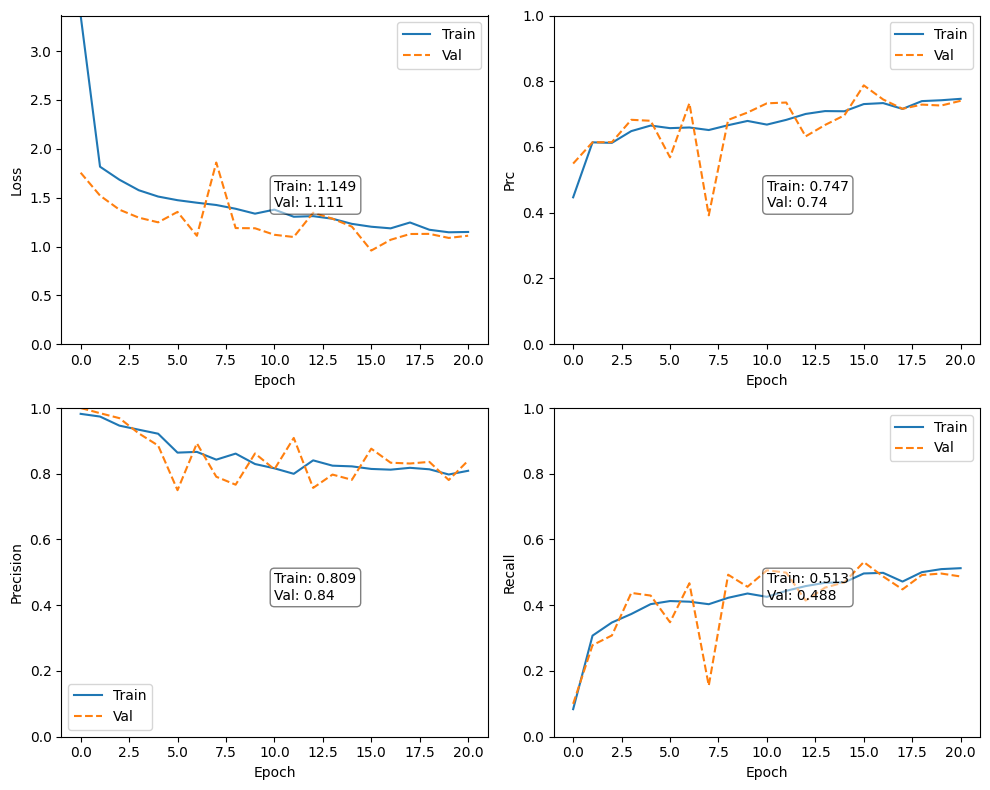

In [ ]:
plot_metrics(history)

In [ ]:
class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

display_labels = [class_names[i] for i in range(len(class_names))]

In [ ]:
model_best_build_preds = model_best_build.predict(X_valid)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


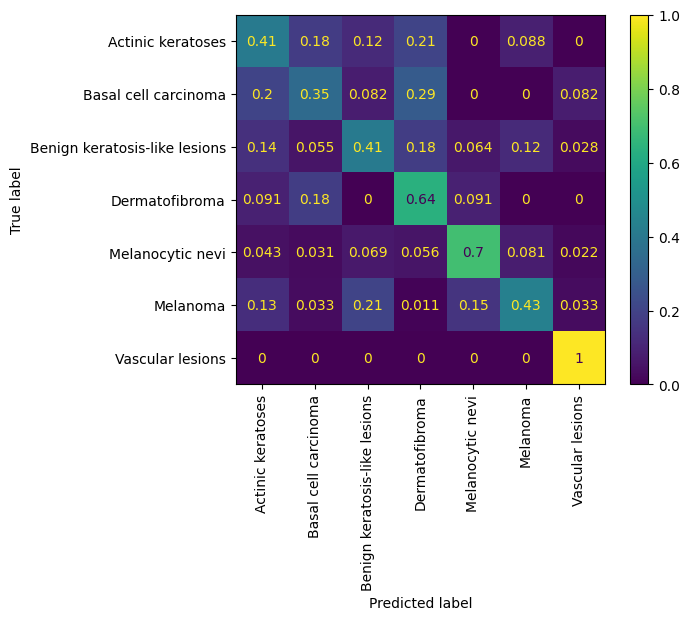

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_valid.argmax(axis=1),
                                        model_best_build_preds.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
print(classification_report(y_valid.argmax(axis=1),
                            model_best_build_preds.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.16      0.41      0.23        34
         Basal cell carcinoma       0.29      0.35      0.31        49
Benign keratosis-like lesions       0.35      0.41      0.38       109
               Dermatofibroma       0.07      0.64      0.13        11
             Melanocytic nevi       0.96      0.70      0.81       810
                     Melanoma       0.33      0.43      0.37        92
             Vascular lesions       0.35      1.00      0.52        15

                     accuracy                           0.63      1120
                    macro avg       0.36      0.56      0.39      1120
                 weighted avg       0.78      0.63      0.68      1120



In [ ]:
calculate_and_print_scores(y_valid.argmax(axis=1), model_best_build_preds.argmax(axis=1))

Matthews Correlation Coefficient (MCC): 0.3981
F-beta Score (macro averaging): 0.4535
F-beta Score (weighted averaging): 0.6426


In [ ]:
model_best_build_train_preds = model_best_build.predict(X_train)

164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


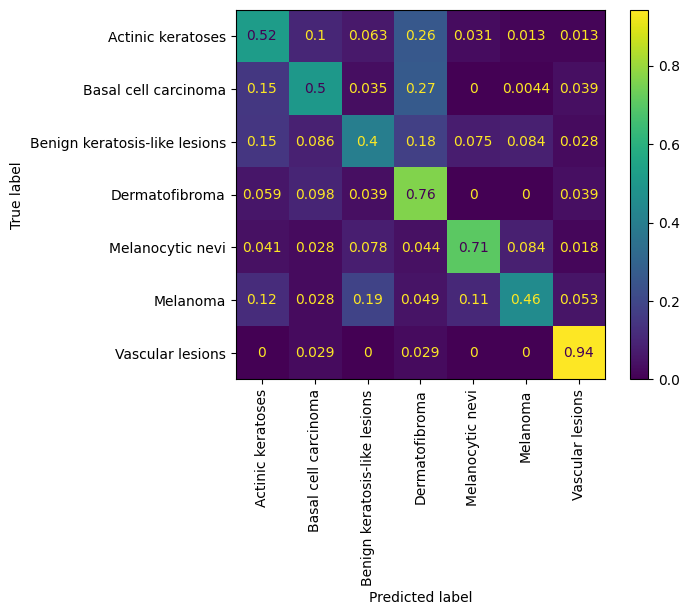

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1),
                                        model_best_build_train_preds.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
print(classification_report(y_train.argmax(axis=1),
                            model_best_build_train_preds.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.21      0.52      0.30       159
         Basal cell carcinoma       0.38      0.50      0.43       229
Benign keratosis-like lesions       0.34      0.40      0.37       509
               Dermatofibroma       0.09      0.76      0.17        51
             Melanocytic nevi       0.97      0.71      0.82      3782
                     Melanoma       0.35      0.46      0.40       430
             Vascular lesions       0.35      0.94      0.51        69

                     accuracy                           0.65      5229
                    macro avg       0.38      0.61      0.43      5229
                 weighted avg       0.79      0.65      0.70      5229



In [ ]:
calculate_and_print_scores(y_train.argmax(axis=1), model_best_build_train_preds.argmax(axis=1))

Matthews Correlation Coefficient (MCC): 0.4258
F-beta Score (macro averaging): 0.4938
F-beta Score (weighted averaging): 0.6586


# Model development with balanced training data 6000

In [ ]:
num_classes = X_balanced_6000_train.shape[1]

In [ ]:
metrics = [
      keras.metrics.FBetaScore(beta=2.0, name='fbeta_score'),
      keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(Input(shape=X_balanced_6000_train.shape[1:]))

    for i in range(hp.Int('n_hidden_layers', 1, 4, default=2)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=8, max_value=256, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(hp.Float(f'l2_{i}', min_value=0.0,
                                                        max_value=0.1, step=0.01))
        ))

        pool_size = (2, 2)
        if model.output_shape[1] >= pool_size[0] and model.output_shape[2] >= pool_size[1]:
          if hp.Choice(f'pooling_{i}', ['max', 'avg']) == 'max':
              model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
          else:
              model.add(AveragePooling2D(pool_size=pool_size, padding='same'))

          model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0,
                                    max_value=0.5, step=0.05)))

    if hp.Boolean('global_average_pooling'):
        model.add(GlobalAveragePooling2D())
    else:
        model.add(GlobalMaxPooling2D())

    model.add(Dropout(hp.Float('dropout_rate_dense', min_value=0.0,
                                      max_value=0.5, step=0.1)))

    model.add(Dense(y_balanced_6000_train.shape[1], activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(
        optimizer=Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model

In [ ]:
tuner_bal = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_prc", direction="max"),
    max_epochs=40,
    factor=3,
    hyperband_iterations=1,
    directory='/content/drive/My Drive/HPOs/HPO_BasicCNN_tr_bal6000',
    project_name="CNNModel_HPO_bal"
)

Reloading Tuner from /content/drive/My Drive/HPO_BasicCNN_tr_bal6000/CNNModel_HPO_bal/tuner0.json


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

In [ ]:
batch_size = 256
epochs = 30

tuner_bal.search(train_datagen_6000.flow(X_train, y_train, batch_size=batch_size),
                epochs=epochs,
                validation_data=val_datagen.flow(X_valid, y_valid),
                callbacks = [early_stopping_monitor, reduce_lr])

Trial 50 Complete [00h 01m 32s]
val_prc: 0.7985799312591553

Best val_prc So Far: 0.8165678977966309
Total elapsed time: 00h 42m 13s

Search: Running Trial #51

Value             |Best Value So Far |Hyperparameter
2                 |2                 |n_hidden_layers
56                |56                |filters_0
3                 |3                 |kernel_size_0
0                 |0                 |l2_0
max               |max               |pooling_0
0                 |0                 |dropout_rate_0
216               |216               |filters_1
5                 |5                 |kernel_size_1
0.04              |0.04              |l2_1
max               |max               |pooling_1
0                 |0                 |dropout_rate_1
False             |False             |global_average_pooling
0.1               |0.1               |dropout_rate_dense
0.00058026        |0.00058026        |learning_rate
56                |56                |filters_2
3                 |3      

KeyboardInterrupt: 

In [ ]:
best_hps_bal = tuner_bal.get_best_hyperparameters()[0]
print(best_hps_bal.values)

{'n_hidden_layers': 2, 'filters_0': 56, 'kernel_size_0': 3, 'l2_0': 0.0, 'pooling_0': 'max', 'dropout_rate_0': 0.0, 'filters_1': 216, 'kernel_size_1': 5, 'l2_1': 0.04, 'pooling_1': 'max', 'dropout_rate_1': 0.0, 'global_average_pooling': False, 'dropout_rate_dense': 0.1, 'learning_rate': 0.0005802593287370159, 'filters_2': 56, 'kernel_size_2': 3, 'l2_2': 0.05, 'pooling_2': 'max', 'dropout_rate_2': 0.4, 'tuner/epochs': 14, 'tuner/initial_epoch': 5, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0040', 'filters_3': 24, 'kernel_size_3': 5, 'l2_3': 0.04, 'pooling_3': 'max', 'dropout_rate_3': 0.05}


In [ ]:
best_model_bal = tuner_bal.get_best_models()[0]
#best_model_comb.save('results/best_model_hpo_comb.keras')

/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model_bal = keras.models.load_model('/content/best_model_hpo_comb.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model_bal.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 100, 56)         │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 38, 50, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 50, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 38, 50, 216)         │         302,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 25, 216)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 25, 216)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 216)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 216)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           1,519 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,703 (1.17 MB)

 Trainable params: 305,703 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 256
epochs = 40

model_best_build_bal = tuner_bal.hypermodel.build(best_hps_bal)
history_bal = model_best_build_bal.fit(train_datagen_6000.flow(X_balanced_6000_train, y_balanced_6000_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_valid, y_valid),
                    callbacks = [early_stopping_monitor])

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - cat_accuracy: 0.3038 - fbeta_score: 0.2705 - loss: 2.8781 - prc: 0.3292 - precision: 0.8559 - recall: 0.0654 - val_cat_accuracy: 0.5875 - val_fbeta_score: 0.3718 - val_loss: 1.4340 - val_prc: 0.6911 - val_precision: 0.9876 - val_recall: 0.3562
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - cat_accuracy: 0.4542 - fbeta_score: 0.4460 - loss: 1.5691 - prc: 0.5172 - precision: 0.9115 - recall: 0.1498 - val_cat_accuracy: 0.6107 - val_fbeta_score: 0.3995 - val_loss: 1.1485 - val_prc: 0.7439 - val_precision: 0.8709 - val_recall: 0.4938
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - cat_accuracy: 0.4906 - fbeta_score: 0.4830 - loss: 1.4676 - prc: 0.5577 - precision: 0.8734 - recall: 0.1941 - val_cat_accuracy: 0.6027 - val_fbeta_score: 0.4301 - val_loss: 1.2918 - val_prc: 0.7010 - val_precision: 0.8988 - val_recall: 0.4518
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - cat_accuracy: 0.5068 - fbeta_score: 0.5020 - loss: 

In [ ]:
#model_best_build_bal.save('fp_model_best_build_comb.keras')

In [ ]:
#model_best_build_bal.save("fp_model_best_build_comb.h5")

In [ ]:
#results = model_best_build_bal.evaluate(X_test, y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.0000e+00 - fbeta_score: 0.1288 - loss: 1.1533 - prc: 0.7255 - precision: 0.8591 - recall: 0.4155


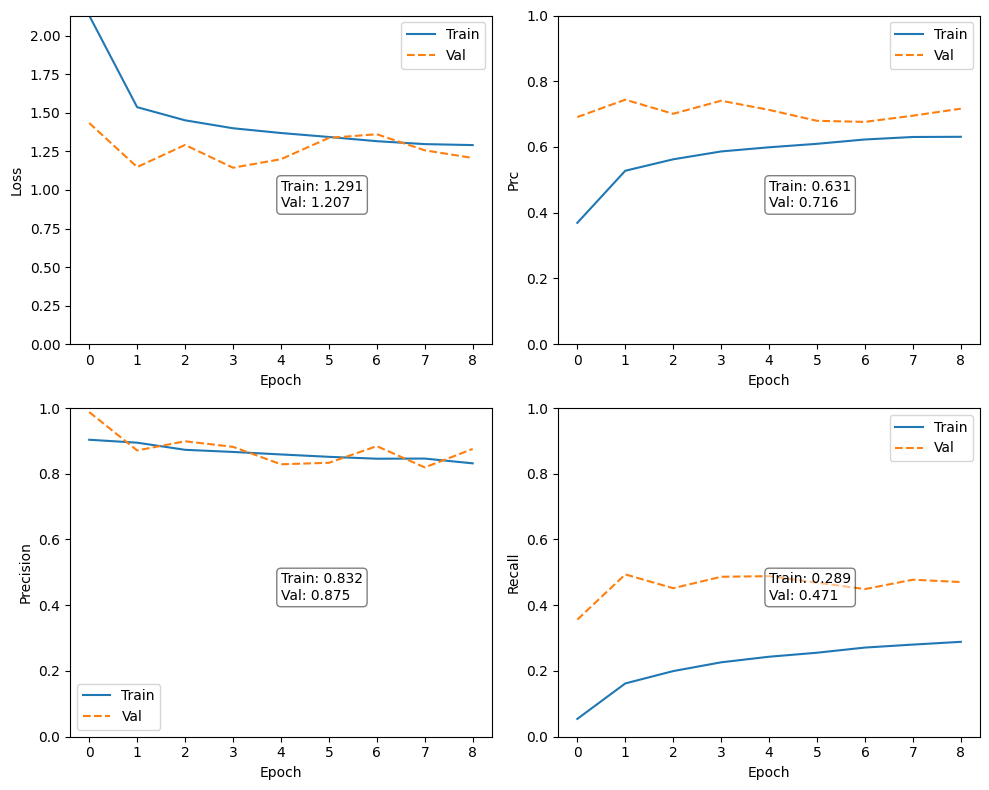

In [ ]:
plot_metrics(history_bal)

In [ ]:
class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

display_labels = [class_names[i] for i in range(len(class_names))]

In [ ]:
comb_model_valid_b = model_best_build_bal.predict(X_valid, batch_size = 128)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step


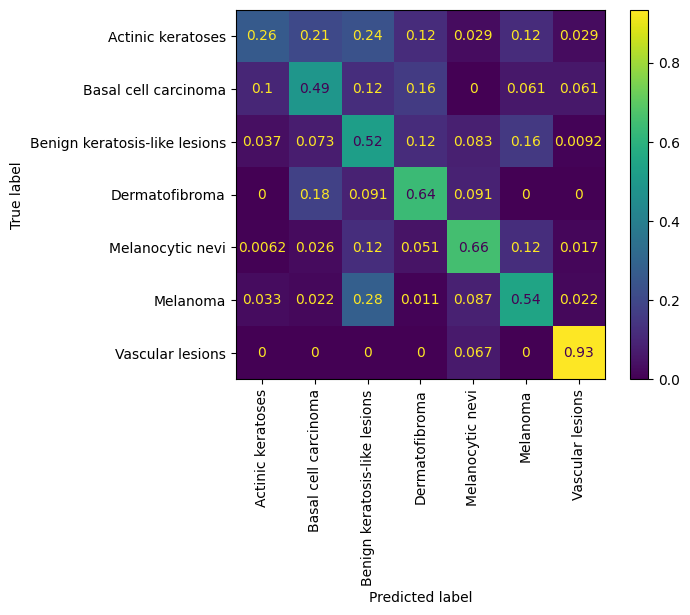

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_valid.argmax(axis=1),
                                        comb_model_valid_b.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
print(classification_report(y_valid.argmax(axis=1),
                            comb_model_valid_b.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.35      0.26      0.30        34
         Basal cell carcinoma       0.38      0.49      0.42        49
Benign keratosis-like lesions       0.29      0.52      0.37       109
               Dermatofibroma       0.09      0.64      0.16        11
             Melanocytic nevi       0.96      0.66      0.78       810
                     Melanoma       0.29      0.54      0.38        92
             Vascular lesions       0.40      0.93      0.56        15

                     accuracy                           0.62      1120
                    macro avg       0.39      0.58      0.43      1120
                 weighted avg       0.78      0.62      0.67      1120



In [ ]:
calculate_and_print_scores(y_valid.argmax(axis=1), comb_model_valid_b.argmax(axis=1))

Matthews Correlation Coefficient (MCC): 0.4045
F-beta Score (macro averaging): 0.4836
F-beta Score (weighted averaging): 0.6297


In [ ]:
model_train_preds_bal = model_best_build_bal.predict(X_train, batch_size = 128)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


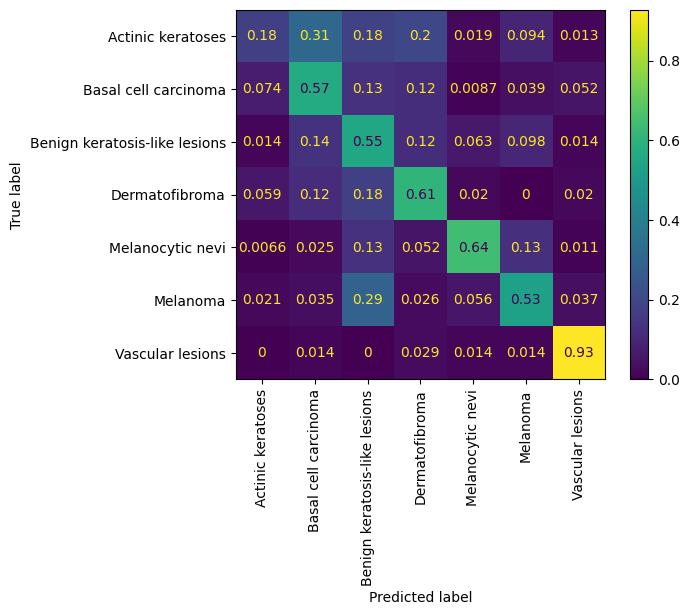

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1),
                                        model_train_preds_bal.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
print(classification_report(y_train.argmax(axis=1),
                            model_train_preds_bal.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.31      0.18      0.23       159
         Basal cell carcinoma       0.36      0.57      0.44       229
Benign keratosis-like lesions       0.29      0.55      0.38       509
               Dermatofibroma       0.09      0.61      0.15        51
             Melanocytic nevi       0.97      0.64      0.78      3782
                     Melanoma       0.29      0.53      0.37       430
             Vascular lesions       0.45      0.93      0.60        69

                     accuracy                           0.61      5229
                    macro avg       0.39      0.57      0.42      5229
                 weighted avg       0.79      0.61      0.66      5229



In [ ]:
calculate_and_print_scores(y_train.argmax(axis=1), model_train_preds_bal.argmax(axis=1))

Matthews Correlation Coefficient (MCC): 0.4072
F-beta Score (macro averaging): 0.4793
F-beta Score (weighted averaging): 0.6232


# Random model tryout with balanced training data

In [ ]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 75, 100, 128)        │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 37, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 25, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 12, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 539,367 (2.06 MB)

 Trainable params: 539,303 (2.06 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
batch_size = 256
epochs = 40

history = model.fit(train_datagen_6000.flow(X_balanced_6000_train, y_balanced_6000_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = val_datagen.flow(X_valid, y_valid),
                              verbose = 1,
                              steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_valid.shape[0] // batch_size),
                              callbacks=[early_stopping_monitor])

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step - cat_accuracy: 0.2487 - fbeta_score: 0.2380 - loss: 4.3900 - prc: 0.2334 - precision: 0.3483 - recall: 0.0447 - val_cat_accuracy: 0.6953 - val_fbeta_score: 0.2420 - val_loss: 3.2745 - val_prc: 0.6834 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - cat_accuracy: 0.4430 - fbeta_score: 0.4461 - loss: 2.7918 - prc: 0.4695 - precision: 0.6619 - recall: 0.1799 - val_cat_accuracy: 0.2734 - val_fbeta_score: 0.1520 - val_loss: 2.7692 - val_prc: 0.3034 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - cat_accuracy: 0.5162 - fbeta_score: 0.5148 - loss: 2.1369 - prc: 0.5726 - precision: 0.7306 - recall: 0.2990 - val_cat_accuracy: 0.5234 - val_fbeta_score: 0.2423 - val_loss: 2.4924 - val_prc: 0.4980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - cat_accuracy: 0.5351 - fbet

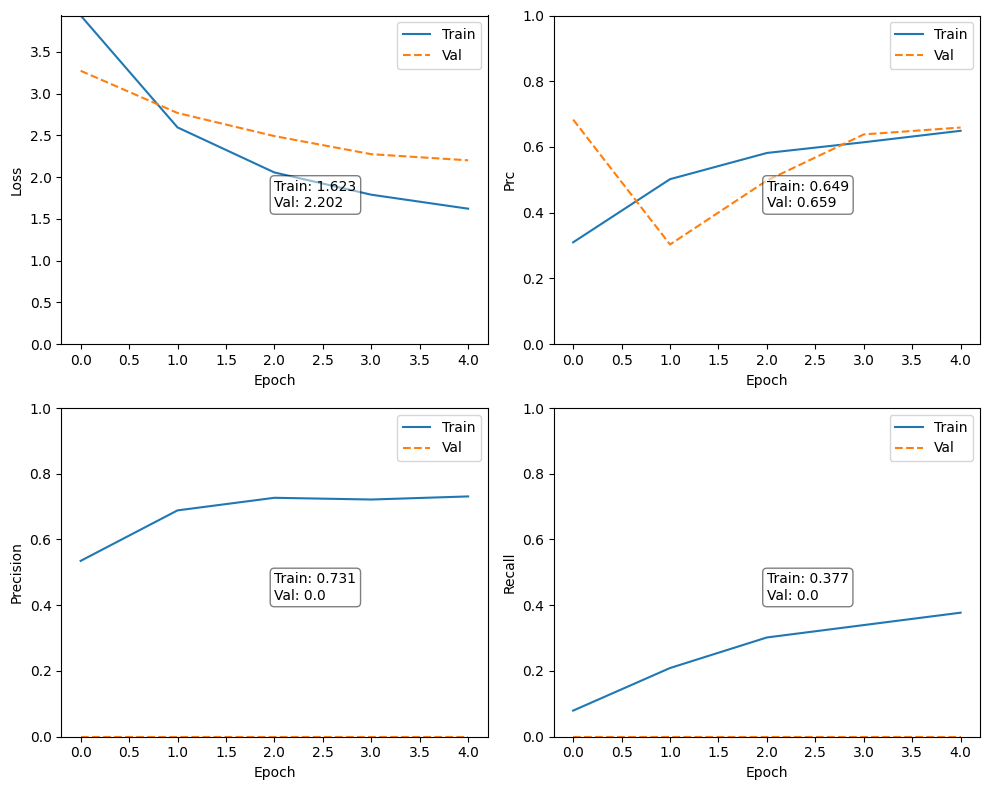

In [ ]:
plot_metrics(history)

In [ ]:
model_valid_r = model.predict(X_valid, batch_size = 128)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step


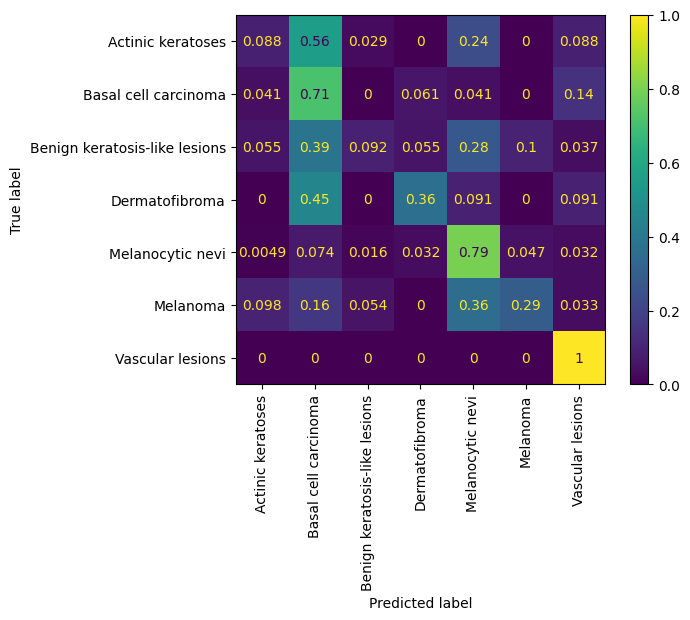

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_valid.argmax(axis=1),
                                        model_valid_r.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
print(classification_report(y_valid.argmax(axis=1),
                            model_valid_r.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.12      0.09      0.10        34
         Basal cell carcinoma       0.20      0.71      0.31        49
Benign keratosis-like lesions       0.34      0.09      0.14       109
               Dermatofibroma       0.10      0.36      0.16        11
             Melanocytic nevi       0.90      0.79      0.84       810
                     Melanoma       0.36      0.29      0.32        92
             Vascular lesions       0.25      1.00      0.41        15

                     accuracy                           0.66      1120
                    macro avg       0.33      0.48      0.33      1120
                 weighted avg       0.73      0.66      0.67      1120



In [ ]:
matthews_corrcoef(y_valid.argmax(axis=1), model_valid_r.argmax(axis=1))

0.3537143325007816

In [ ]:
fbeta_score(y_valid.argmax(axis=1), model_valid_r.argmax(axis=1),
            average='macro',
            beta=2.0)

0.3799230292527647

In [ ]:
fbeta_score(y_valid.argmax(axis=1), model_valid_r.argmax(axis=1),
            average='weighted',
            beta=2.0)

0.6572755075789213

In [ ]:
model_train_r = model_best_build_bal.predict(X_train, batch_size = 128)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


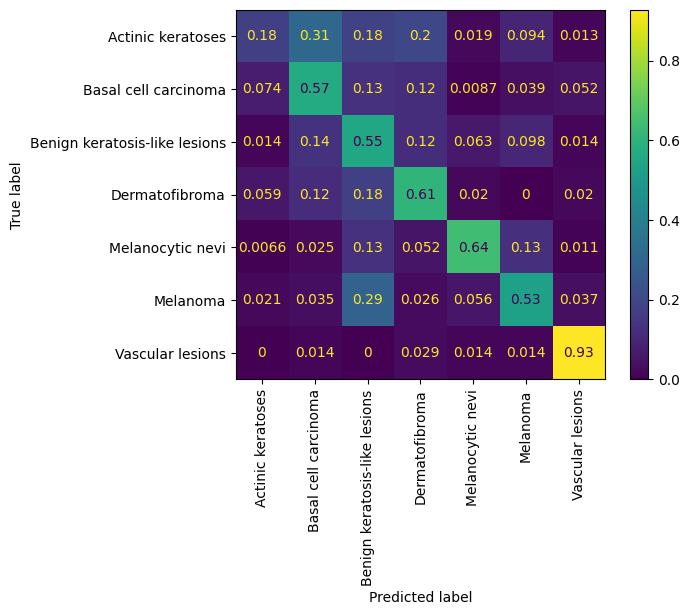

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1),
                                        model_train_r.argmax(axis=1),
                                        display_labels=display_labels,
                                        xticks_rotation = "vertical",
                                        normalize='true')

In [ ]:
print(classification_report(y_train.argmax(axis=1),
                            model_train_r.argmax(axis=1),
                            target_names=display_labels))

                               precision    recall  f1-score   support

            Actinic keratoses       0.31      0.18      0.23       159
         Basal cell carcinoma       0.36      0.57      0.44       229
Benign keratosis-like lesions       0.29      0.55      0.38       509
               Dermatofibroma       0.09      0.61      0.15        51
             Melanocytic nevi       0.97      0.64      0.78      3782
                     Melanoma       0.29      0.53      0.37       430
             Vascular lesions       0.45      0.93      0.60        69

                     accuracy                           0.61      5229
                    macro avg       0.39      0.57      0.42      5229
                 weighted avg       0.79      0.61      0.66      5229



In [ ]:
matthews_corrcoef(y_train.argmax(axis=1), model_train_r.argmax(axis=1))

0.40723533434767006

In [ ]:
fbeta_score(y_train.argmax(axis=1), model_train_r.argmax(axis=1),
            average='macro',
            beta=2.0)

0.4792852265372166

In [ ]:
fbeta_score(y_train.argmax(axis=1), model_train_r.argmax(axis=1),
            average='weighted',
            beta=2.0)

0.6232012407806501

In [ ]:
def calculate_and_print_scores(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    print("Matthews Correlation Coefficient (MCC): {:.4f}".format(mcc))

    fbeta_macro = fbeta_score(y_true, y_pred, average='macro', beta=2.0)
    print("F-beta Score (macro averaging): {:.4f}".format(fbeta_macro))

    fbeta_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2.0)
    print("F-beta Score (weighted averaging): {:.4f}".format(fbeta_weighted))

In [ ]:
calculate_and_print_scores(y_train.argmax(axis=1), model_train_r.argmax(axis=1))

Matthews Correlation Coefficient (MCC): 0.4072
F-beta Score (macro averaging): 0.4793
F-beta Score (weighted averaging): 0.6232
